<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

import requests

### Datos
Utilizaremos como dataset 2 famosos libros de política.

In [ ]:
result1 = requests.get("https://www.gutenberg.org/cache/epub/17405/pg17405.txt") # The Art of War - Sun Tzu

result2 = requests.get("https://www.gutenberg.org/cache/epub/1232/pg1232.txt") # The Prince - Machiavelli

result = result1.text + result2.text

df = pd.DataFrame(result.split('\n'), columns=['documents'])
df['documents'] = df['documents'].str.replace('\r','')
df = df[df['documents'].str.len() > 2] # Sacamos artículos, caracteres y filas con espacios vacíos
df.head()

,documents
0,﻿The Project Gutenberg eBook of The Art of War
1,
2,This ebook is for the use of anyone anywhere i...
3,most other parts of the world at no cost and w...
4,"whatsoever. You may copy it, give it away or r..."


In [ ]:
df.documents.str.len().describe()

,documents
count,6006.000000
mean,62.648019
std,14.862511
min,4.000000
25%,65.000000
50%,68.000000
75%,70.000000
max,163.000000


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 6006


### 1 - Preprocesamiento

In [ ]:
#!pip uninstall keras
#!pip install tensorflow

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import text_to_word_sequence

#from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
  filtered_words = [word for word in text_to_word_sequence(row[0]) if len(word) >= 3]
  sentence_tokens.append(filtered_words)

<ipython-input-320-17151747e510>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
## Demos un vistazo
sentence_tokens[:2]

[['\ufeffthe', 'project', 'gutenberg', 'ebook', 'the', 'art', 'war'], []]

### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=3,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=5,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 6006


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 1479


### 3 - Entrenar embeddings

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=200,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 333931.28125
Loss after epoch 1: 255638.78125
Loss after epoch 2: 241802.875
Loss after epoch 3: 238255.1875
Loss after epoch 4: 233003.125
Loss after epoch 5: 231891.25
Loss after epoch 6: 231345.875
Loss after epoch 7: 227512.25
Loss after epoch 8: 228365.875
Loss after epoch 9: 227610.25
Loss after epoch 10: 220226.5
Loss after epoch 11: 215771.0
Loss after epoch 12: 211193.75
Loss after epoch 13: 206218.5
Loss after epoch 14: 203199.5
Loss after epoch 15: 196977.0
Loss after epoch 16: 193684.75
Loss after epoch 17: 188576.75
Loss after epoch 18: 176249.5
Loss after epoch 19: 160211.0
Loss after epoch 20: 157275.5
Loss after epoch 21: 156369.5
Loss after epoch 22: 153696.0
Loss after epoch 23: 152332.0
Loss after epoch 24: 148721.0
Loss after epoch 25: 148331.0
Loss after epoch 26: 146244.5
Loss after epoch 27: 144702.0
Loss after epoch 28: 144575.5
Loss after epoch 29: 141347.0
Loss after epoch 30: 140805.0
Loss after epoch 31: 139192.5
Loss after epoch 32: 1381

(6387692, 10521400)

### 4 - Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["war"], topn=10)

[('tzŭ', 0.38652002811431885),
 ('sun', 0.36436697840690613),
 ('manœuvering', 0.3381493389606476),
 ('excuse', 0.32980969548225403),
 ('art', 0.3283252716064453),
 ('material', 0.3231935203075409),
 ('host', 0.3182224929332733),
 ('estimation', 0.31747177243232727),
 ('happened', 0.3143501281738281),
 ('events', 0.31057009100914)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["war"], topn=10)

[('fortunes', 0.07391022890806198),
 ('noble', 0.06761544197797775),
 ('excellent', 0.06374768167734146),
 ('access', 0.06007102131843567),
 ('mercenaries', 0.03574304282665253),
 ('leave', 0.030406242236495018),
 ('yielded', 0.028868719935417175),
 ('religion', 0.02527041919529438),
 ('discuss', 0.02398735284805298),
 ('expense', 0.02363906428217888)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["art"], topn=10)

[('sun', 0.45681846141815186),
 ('tzŭ', 0.42218896746635437),
 ('estimation', 0.40213772654533386),
 ('facing', 0.3975624740123749),
 ('purpose', 0.3789113461971283),
 ('importance', 0.3647722601890564),
 ('removed', 0.3629460632801056),
 ('door', 0.35697636008262634),
 ('ebook', 0.35450026392936707),
 ('control', 0.34600281715393066)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["peace"], topn=10)

[('new', 0.06524360179901123),
 ('other', 0.05009600520133972),
 ('immediate', 0.04050737991929054),
 ('station', 0.0354146733880043),
 ('powerful', 0.024143822491168976),
 ('wishes', 0.022902654483914375),
 ('julius', 0.021565651521086693),
 ('private', 0.020493650808930397),
 ('due', 0.019440341740846634),
 ('della', 0.017890827730298042)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["peace"], topn=5)

[('superior', 0.37503477931022644),
 ('lest', 0.3606691360473633),
 ('robbed', 0.3566150665283203),
 ('events', 0.33684679865837097),
 ('prudence', 0.32773712277412415)]

In [ ]:
try:
  # Ensayar con una palabra que no está en el vocabulario:
  w2v_model.wv.most_similar(negative=["dancing"])
except Exception as e:
  print(e)

"Key 'dancing' not present in vocabulary"


In [ ]:
# el método `get_vector` permite obtener los vectores:
vector_war = w2v_model.wv.get_vector("war")
print(vector_war)

[-3.03380638e-02 -2.19493080e-02  1.34104684e-01 -1.19929500e-01
 -5.52028298e-01  9.82373729e-02  6.94627404e-01  3.87251019e-01
 -4.59422201e-01 -4.29738283e-01 -3.04228008e-01 -3.22544634e-01
 -6.18464909e-02 -4.73222882e-01 -3.04364204e-01  4.92188185e-01
 -2.45470107e-01 -3.57994586e-01  8.23144391e-02 -6.15884244e-01
 -6.35161996e-02 -3.88620526e-01  1.02034114e-01 -2.49597710e-02
  2.89988101e-01 -1.05667941e-01  2.83073913e-02 -6.05990529e-01
 -7.15077817e-01  6.07728362e-01  2.30791047e-01 -6.40312210e-02
 -2.11379394e-01 -5.27893305e-01 -3.99590433e-02  9.91235077e-02
 -4.65102911e-01 -3.74243319e-01 -4.04439628e-01 -2.01405361e-01
  5.39266944e-01  1.70315176e-01  2.72327065e-01 -5.46972036e-01
 -2.34230831e-01  1.19715817e-01 -1.90597758e-01  2.26912238e-02
 -8.16764176e-01  7.82432333e-02  3.52131315e-02  1.56388246e-02
  1.26102060e-01  2.56046467e-02 -1.60164461e-01  1.88638017e-01
  2.18353137e-01  4.85251367e-01  1.79190770e-01  2.02153191e-01
 -2.43174806e-01  1.53479

In [ ]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_war)

[('war', 0.9999999403953552),
 ('tzŭ', 0.38652002811431885),
 ('sun', 0.36436697840690613),
 ('manœuvering', 0.3381493389606476),
 ('excuse', 0.32980969548225403),
 ('art', 0.3283252716064453),
 ('material', 0.3231935203075409),
 ('host', 0.3182225227355957),
 ('estimation', 0.31747180223464966),
 ('happened', 0.3143501281738281)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["war"], topn=10)

[('tzŭ', 0.38652002811431885),
 ('sun', 0.36436697840690613),
 ('manœuvering', 0.3381493389606476),
 ('excuse', 0.32980969548225403),
 ('art', 0.3283252716064453),
 ('material', 0.3231935203075409),
 ('host', 0.3182224929332733),
 ('estimation', 0.31747177243232727),
 ('happened', 0.3143501281738281),
 ('events', 0.31057009100914)]

### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro
dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

# Conclusión y análisis:

Se entrenó utilizando las siguientes pruebas:

Variando:

*   Negative sampling
*   Minimo de caracteres por elemento
*   Epochs
*   Window
*   Vector Size

Respecto a los términos de interés y su similitud, para "war" tenemos su vector:

[('war', 0.9999999403953552),
 ('tzŭ', 0.38652002811431885),
 ('sun', 0.36436697840690613),
 ('manœuvering', 0.3381493389606476),
 ('excuse', 0.32980969548225403),
 ('art', 0.3283252716064453),
 ('material', 0.3231935203075409),
 ('host', 0.3182225227355957),
 ('estimation', 0.31747180223464966),
 ('happened', 0.3143501281738281)]

Y los vectores más similares:

[('tzŭ', 0.38652002811431885),
 ('sun', 0.36436697840690613),
 ('manœuvering', 0.3381493389606476),
 ('excuse', 0.32980969548225403),
 ('art', 0.3283252716064453),
 ('material', 0.3231935203075409),
 ('host', 0.3182224929332733),
 ('estimation', 0.31747177243232727),
 ('happened', 0.3143501281738281),
 ('events', 0.31057009100914)]

Esto nos indica que la palabra se menciona más frecuentemente en la ventana de contexto del título del primer libro del corpus "The art of war - Sun Tzŭ".

En la representación 3D puede evidenciarse la centralidad de la palabra "war" (guerra) en los embeddings. Llama la atención que no se encuentra como centro de un clusters pero si equidistante de casi el resto de los vectores de embeddings.





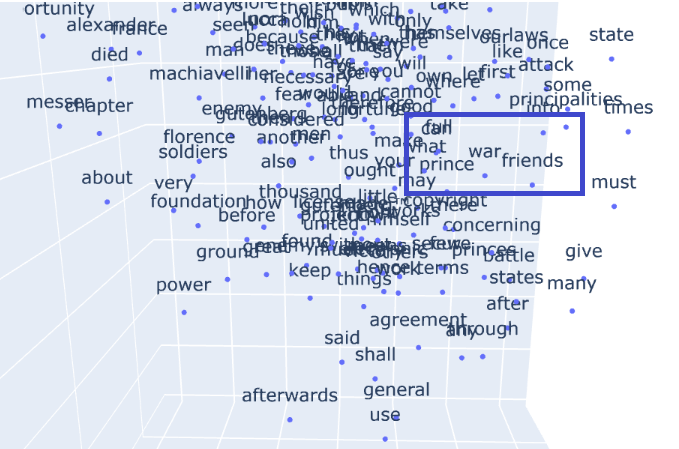